# Tema 3 - Clasificare de fete

## Importuri

In [ ]:
from copy import deepcopy
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running code @ {device}')

!pip3 install facenet_pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

Running code @ cuda


## Procesarea seturilor de date

In [ ]:
def get_dataset():
    return fetch_lfw_people(color=True)


def get_small_dataset(og_ds, num_classes=5):
    uniq, elem = np.unique(og_ds['target'], return_counts=True)
    most_common = list(dict(sorted(zip(uniq, elem), key=lambda p: p[1], reverse=True)[:num_classes]).keys())

    images = []
    targets = []
    for i, cls in enumerate(og_ds['target']):
        if cls in most_common:
            images.append(og_ds['images'][i])
            targets.append(most_common.index(cls))

    return {
        'images': np.array(images),
        'target': np.array(targets),
        'target_names': np.array([og_ds['target_names'][tgt] for tgt in set(most_common)])
    }

# _ = get_og_dataset()

In [ ]:
class FacesDataSet(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.trans = transforms.Compose([transforms.ToTensor()])


    def __len__(self):
        return len(self.y)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
  
        return self.trans(self.X[idx]), self.y[idx]
  


class FacesDataSetImproved(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])


    def __len__(self):
        return len(self.y)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
  
        return self.trans(self.X[idx]), self.y[idx]

In [ ]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 100
NO_WORKERS = 2
SHUFFLE_DATA = True


DS = get_dataset()
SMALL_DS = get_small_dataset(DS)

X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(
    SMALL_DS['images'], SMALL_DS['target'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(DS['images'], DS['target'],
    test_size=0.2, random_state=42)

small_test_loader = torch.utils.data.DataLoader(FacesDataSet(X_small_test, y_small_test),
    batch_size=BATCH_SIZE_TRAIN, shuffle=SHUFFLE_DATA, num_workers=NO_WORKERS)
small_train_loader = torch.utils.data.DataLoader(FacesDataSet(X_small_train, y_small_train),
    batch_size=BATCH_SIZE_TRAIN, shuffle=SHUFFLE_DATA, num_workers=NO_WORKERS)
test_loader = torch.utils.data.DataLoader(FacesDataSet(X_test, y_test),
    batch_size=BATCH_SIZE_TRAIN, shuffle=SHUFFLE_DATA, num_workers=NO_WORKERS)
train_loader = torch.utils.data.DataLoader(FacesDataSet(X_train, y_train),
    batch_size=BATCH_SIZE_TRAIN, shuffle=SHUFFLE_DATA, num_workers=NO_WORKERS)

batch_train_images, batch_train_labels = next(iter(train_loader))
batch_train_images_small, batch_train_labels_small = next(iter(small_train_loader))

def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

## Cerinta 1 - modelul MLP

In [33]:
class MLP(nn.Module):
    def __init__(self, width, height, n_chan, n_cls):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(n_chan * width * height, 128)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(128, 128)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(128, n_cls)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        x = self.sigmoid(x)

        return x


class ImprovedMLP(nn.Module):
    def __init__(self, width, height, n_chan, n_cls):
        super(ImprovedMLP, self).__init__()
        self.fc1 = nn.Linear(n_chan * width * height, n_cls)
        self.bn1 = nn.BatchNorm1d(n_cls)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.sigmoid(x)

        return x


_, chan, w, h = batch_train_images.size()
mlp_net = MLP(w, h, chan, 5)
mlp_net = mlp_net.to(device)

print(list(mlp_net.modules())[0])


select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = mlp_net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

MLP(
  (fc1): Linear(in_features=8742, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (sigmoid): Sigmoid()
)
tensor([[1.0000e+00, 1.1152e-12, 3.0123e-05, 9.8942e-01, 8.5811e-07],
        [1.0000e+00, 1.0873e-07, 8.0242e-03, 9.9999e-01, 1.1273e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0, 0], device='cuda:0')
tensor([3389, 1933])


## Cerinta 2 - Modelul CNN

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, width, height, n_chan, n_cls):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(n_chan, 8, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.25)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.25)

        w_conv1 = (width - 5) + 1
        h_conv1 = (height - 5) + 1
        w_conv2 = (w_conv1 - 5) + 1
        h_conv2 = (h_conv1 - 5) + 1
        w_pool1 = (w_conv2 - 2) // 2 + 1
        h_pool1 = (h_conv2 - 2) // 2 + 1

        w_conv3 = (w_pool1 - 3) + 1
        h_conv3 = (h_pool1 - 3) + 1
        w_conv4 = (w_conv3 - 3) + 1
        h_conv4 = (h_conv3 - 3) + 1
        w_pool2 = (w_conv4 - 2) // 2 + 1
        h_pool2 = (h_conv4 - 2) // 2 + 1

        in_dense = 64 * w_pool2 * h_pool2

        self.dense1 = nn.Linear(in_dense, 200)
        self.dropout3 = nn.Dropout(p=0.4)
        self.dense2 = nn.Linear(200, out_features=n_cls)
        self.dropout4 = nn.Dropout(p=0.4)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.dense1(x)
        x = self.dropout3(x)

        x = torch.flatten(x, 1)
        x = self.dense2(x)
        x = self.dropout4(x)

        return x

_, chan, w, h = batch_train_images.size()
conv_net = ConvNet(w, h, chan, 5)
conv_net = conv_net.to(device)

print(list(conv_net.modules())[0])


select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = conv_net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (dense1): Linear(in_features=4928, out_features=200, bias=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (dense2): Linear(in_features=200, out_features=5, bias=True)
  (dropout4): Dropout(p=0.4, inplace=False)
)
tensor([[ 0.0000, 35.7718, -3.4438,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  3.0900]], device='cuda:0',
       grad_fn=<FusedDropoutBackward>)
tensor([1, 4], device='cuda:0')
tensor([3389, 1933])


## Bonus - VGG

In [ ]:
def get_ds_facenet_vectors(net, mtcnn, images, labels):
    res = []
    removed = []
    new_labels = deepcopy(labels)

    for i, img in enumerate(images):
        img = mtcnn(img)
        if img is None:
            removed.append(i)
        else:
            res.append(net(img.unsqueeze(0)).squeeze(0).detach().numpy())

    new_labels = np.delete(new_labels, removed)

    return res, new_labels


def classify_SVC(model, net, mtcnn, X_train, X_test, y_train, y_test):
    X_train, y_train = get_ds_facenet_vectors(net, mtcnn, X_train, y_train)
    X_test, y_test = get_ds_facenet_vectors(net, mtcnn, X_test, y_test)

    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f'SVC accuracy = {accuracy_score(y_test, y_pred)}')

In [ ]:
classify_SVC(SVC(),
    InceptionResnetV1(pretrained='vggface2').eval(),
    MTCNN(margin=32, select_largest=False, post_process=False, device=device),
    X_train, X_test, y_train, y_test)

SVC accuracy = 0.046377922575699504


In [ ]:
classify_SVC(SVC(),
    InceptionResnetV1(pretrained='vggface2').eval(),
    MTCNN(margin=32, select_largest=False, post_process=False, device=device),
    X_small_train, X_small_test, y_small_train, y_small_test)

SVC accuracy = 0.5758928571428571


## Testarea algoritmilor

In [ ]:
TRAIN_ITERS = 100e3
REPORT_TRAIN_EVERY = 100
PLOT_EVERY = 100
REPORT_TEST_EVERY = 100
TEST_ITERS = 100

lr_init = 0.01
lr_factor = 0.1
lr_schedule_milestones = [90e3, 100e3, 110e3]


def plot_stat(stat_list, steps, title, y_label):
    pl.plot(steps, stat_list, c='b')
    pl.title(f'{title}')
    pl.xlabel('Numar de batchuri')
    pl.ylabel(y_label)
    pl.show()


def top_k_accuracy(k, target, output):
    batch_size = target.size(0)
    
    _, pred = output.topk(k, 1, True, True)
    
    pred = pred.t()
    correct = pred.eq(target.to(device).view(1, -1).expand_as(pred))

    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
    correct_k.mul_(100.0 / batch_size)
    
    return correct_k


def test_alg(net, loader_train, loader_test, optimiser, epochs):
    train_iter = 0
    losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    steps = []
    test_steps = []

    criterion = nn.CrossEntropyLoss()
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones=lr_schedule_milestones, gamma=lr_factor)
    test_data_provider = loopy_test_loader(loader_test)

    net.train()

    running_loss = 0.0
    running_acc = 0.0
    ct = 0

    for epoch in range(epochs):
        for i, data in enumerate(loader_train, 0):
            lr_scheduler.step()
            inputs, labels = data[0].to(device), data[1].to(device)
            optimiser.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()

            running_loss += loss.item()
            running_acc += top_k_accuracy(1, labels, outputs)
            
            if train_iter % REPORT_TRAIN_EVERY == REPORT_TRAIN_EVERY - 1:
                train_loss = running_loss / REPORT_TRAIN_EVERY
                train_acc = running_acc / REPORT_TRAIN_EVERY
                
                print('[%d, %5d, %6d] LR: %.5f' % (epoch + 1, i + 1, train_iter, lr_scheduler.get_lr()[-1]))
                print('[%d, %5d] loss: %.5f, acc: %.5f' %
                    (epoch + 1, i + 1, train_loss, train_acc))
                
                losses.append(train_loss)
                steps.append(train_iter)
                train_accs.append(train_acc)
                
                running_loss = 0
                train_loss = 0
                running_acc = 0
                train_acc = 0
                
            train_iter += 1
        
            if train_iter % REPORT_TEST_EVERY == 0:
                net.eval()
                
                with torch.no_grad():
                    test_iter = 0
                    test_loss = 0
                    correct = 0
                    
                    while test_iter < TEST_ITERS:
                        test_data = next(test_data_provider)
                        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)

                        out = net(test_inputs)
                        test_loss += criterion(out, test_labels)

                        correct += top_k_accuracy(1, test_labels, out)
                        test_iter += 1
                            
                    avg_test_loss = test_loss / TEST_ITERS
                    avg_acc = correct / TEST_ITERS
                    test_accs.append(avg_acc)
                    test_losses.append(avg_test_loss)
                    test_steps.append(train_iter)
                    
                    print('[%d, %5d] avg_test_loss: %.5f, avg_test_acc: %.2f' 
                        % (epoch + 1, i + 1, avg_test_loss, avg_acc))
                    
                net.train()

    plot_stat(train_accs, steps, 'Acuratete pe setul de antrenare', 'Acuratete')
    plot_stat(losses, steps, 'Loss pe setul de antrenare', 'Valoarea functiei de loss')

    plot_stat(test_accs, test_steps,'Acuratete pe setul de testare', 'Acuratete')
    plot_stat(test_losses, test_steps, 'Loss pe setul de testare', 'Valoarea functiei de loss')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,   100,     99] LR: 0.01000
[1,   100] loss: 5649.32688, acc: 0.21000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


[1,   100] avg_test_loss: 90.10613, avg_test_acc: 0.04
[2,    94,    199] LR: 0.01000
[2,    94] loss: 38.77558, acc: 0.36000
[2,    94] avg_test_loss: 88.92995, avg_test_acc: 0.00
[3,    88,    299] LR: 0.01000
[3,    88] loss: 24.24346, acc: 0.53000
[3,    88] avg_test_loss: 57.99676, avg_test_acc: 0.05
[4,    82,    399] LR: 0.01000
[4,    82] loss: 17.33759, acc: 0.76000
[4,    82] avg_test_loss: 30.68665, avg_test_acc: 0.00
[5,    76,    499] LR: 0.01000
[5,    76] loss: 14.13016, acc: 1.10163
[5,    76] avg_test_loss: 22.94894, avg_test_acc: 0.03
[6,    70,    599] LR: 0.01000
[6,    70] loss: 11.82055, acc: 1.56326
[6,    70] avg_test_loss: 16.75553, avg_test_acc: 0.00
[7,    64,    699] LR: 0.01000
[7,    64] loss: 10.57131, acc: 1.87163
[7,    64] avg_test_loss: 12.32230, avg_test_acc: 0.00
[8,    58,    799] LR: 0.01000
[8,    58] loss: 9.57122, acc: 3.15163
[8,    58] avg_test_loss: 11.58802, avg_test_acc: 0.00
[9,    52,    899] LR: 0.01000
[9,    52] loss: 8.89098, acc: 4.

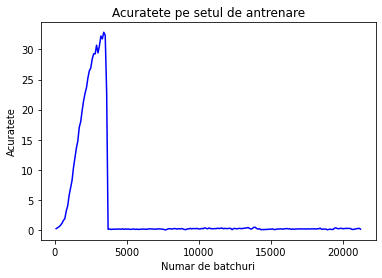

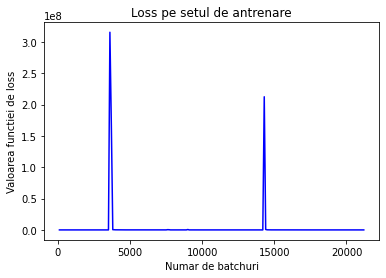

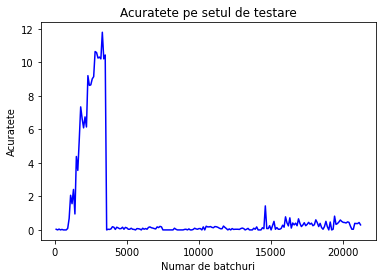

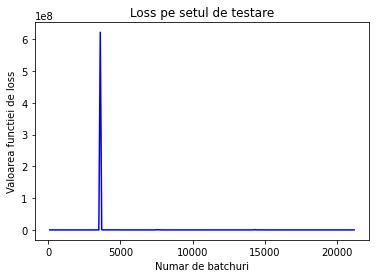

In [ ]:
_, chan, w, h = batch_train_images.size()
net = ConvNet(w, h, chan, len(DS['target_names'])).to(device)

test_alg(net,
    train_loader, test_loader,
    torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-4),
    200)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[10,    10,     99] LR: 0.01000
[10,    10] loss: 6237.26861, acc: 33.99333


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


[10,    10] avg_test_loss: 22.24756, avg_test_acc: 59.37
[20,    10,    199] LR: 0.01000
[20,    10] loss: 16.36850, acc: 54.18333
[20,    10] avg_test_loss: 4.62199, avg_test_acc: 73.00
[30,    10,    299] LR: 0.01000
[30,    10] loss: 6.76127, acc: 61.08000
[30,    10] avg_test_loss: 3.42637, avg_test_acc: 75.97
[40,    10,    399] LR: 0.01000
[40,    10] loss: 4.68819, acc: 65.06333
[40,    10] avg_test_loss: 3.13750, avg_test_acc: 74.36
[50,    10,    499] LR: 0.01000
[50,    10] loss: 3.38110, acc: 68.10999
[50,    10] avg_test_loss: 2.04142, avg_test_acc: 77.33
[60,    10,    599] LR: 0.01000
[60,    10] loss: 2.32252, acc: 71.30333
[60,    10] avg_test_loss: 2.11940, avg_test_acc: 79.27
[70,    10,    699] LR: 0.01000
[70,    10] loss: 1.90582, acc: 73.58000
[70,    10] avg_test_loss: 1.65559, avg_test_acc: 80.39
[80,    10,    799] LR: 0.01000
[80,    10] loss: 1.67439, acc: 74.65667
[80,    10] avg_test_loss: 1.46617, avg_test_acc: 83.56
[90,    10,    899] LR: 0.01000
[90,   

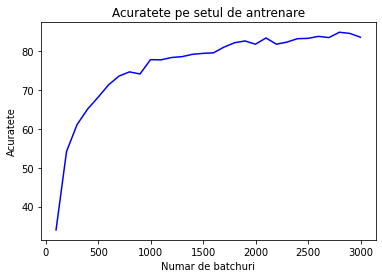

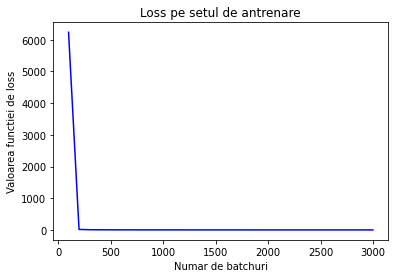

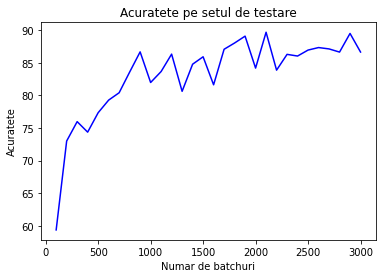

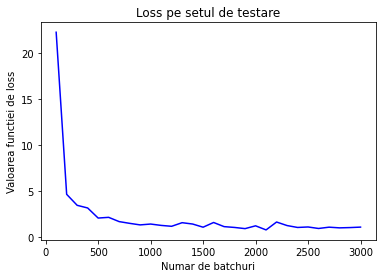

In [38]:
_, chan, w, h = batch_train_images.size()
net = ConvNet(w, h, chan, len(SMALL_DS['target_names'])).to(device)

test_alg(net,
    small_train_loader, small_test_loader,
    torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-4),
    300)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[10,    10,     99] LR: 0.01000
[10,    10] loss: 1.59710, acc: 45.46333


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


[10,    10] avg_test_loss: 1.53909, avg_test_acc: 47.13
[20,    10,    199] LR: 0.01000
[20,    10] loss: 1.58986, acc: 46.40667
[20,    10] avg_test_loss: 1.43363, avg_test_acc: 47.12
[30,    10,    299] LR: 0.01000
[30,    10] loss: 1.44370, acc: 46.11333
[30,    10] avg_test_loss: 1.43842, avg_test_acc: 46.64
[40,    10,    399] LR: 0.01000
[40,    10] loss: 1.55123, acc: 33.42999
[40,    10] avg_test_loss: 1.60944, avg_test_acc: 10.65
[50,    10,    499] LR: 0.01000
[50,    10] loss: 1.60944, acc: 14.38000
[50,    10] avg_test_loss: 1.60944, avg_test_acc: 10.67
[60,    10,    599] LR: 0.01000
[60,    10] loss: 1.46734, acc: 43.27333
[60,    10] avg_test_loss: 1.43723, avg_test_acc: 46.76
[70,    10,    699] LR: 0.01000
[70,    10] loss: 1.44883, acc: 45.59999
[70,    10] avg_test_loss: 1.43648, avg_test_acc: 46.84
[80,    10,    799] LR: 0.01000
[80,    10] loss: 1.43710, acc: 46.77333
[80,    10] avg_test_loss: 1.43722, avg_test_acc: 46.76
[90,    10,    899] LR: 0.01000
[90,    1

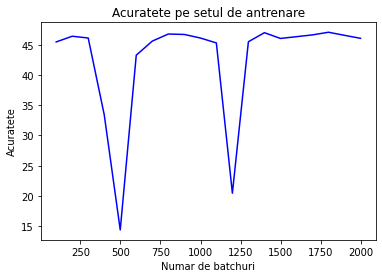

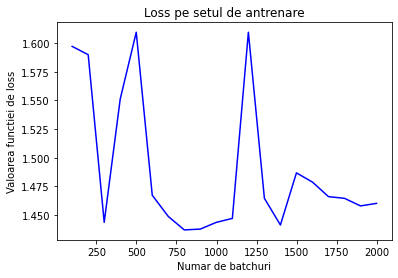

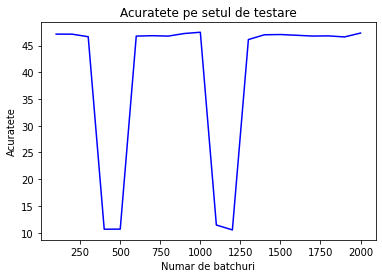

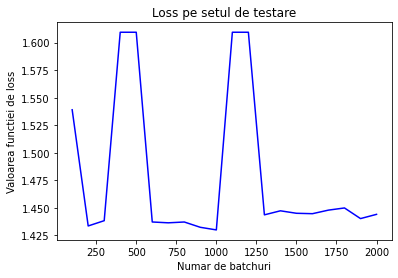

In [ ]:
_, chan, w, h = batch_train_images_small.size()
net = MLP(w, h, chan, len(SMALL_DS['target_names'])).to(device)

test_alg(net,
    small_train_loader, small_test_loader,
    torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-4),
    200)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[10,    10,     99] LR: 0.01000
[10,    10] loss: 1.36690, acc: 64.95333


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


[10,    10] avg_test_loss: 1.40658, avg_test_acc: 57.54
[20,    10,    199] LR: 0.01000
[20,    10] loss: 1.13083, acc: 91.07999
[20,    10] avg_test_loss: 1.27155, avg_test_acc: 68.39
[30,    10,    299] LR: 0.01000
[30,    10] loss: 1.04077, acc: 95.88000
[30,    10] avg_test_loss: 1.21038, avg_test_acc: 72.92
[40,    10,    399] LR: 0.01000
[40,    10] loss: 0.99454, acc: 97.88667
[40,    10] avg_test_loss: 1.36342, avg_test_acc: 67.09
[50,    10,    499] LR: 0.01000
[50,    10] loss: 0.97244, acc: 98.77334
[50,    10] avg_test_loss: 1.15685, avg_test_acc: 78.14


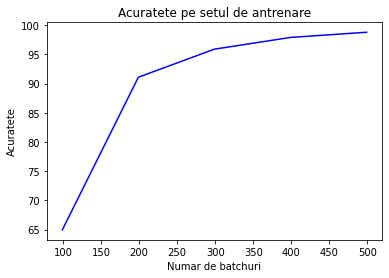

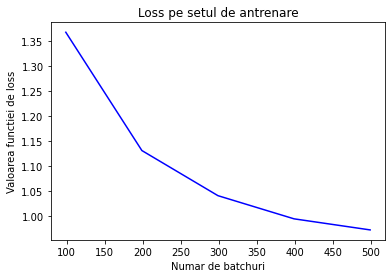

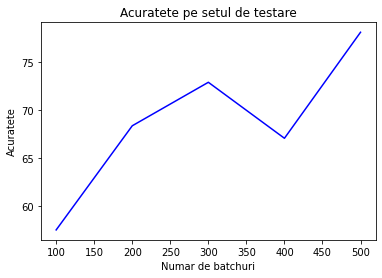

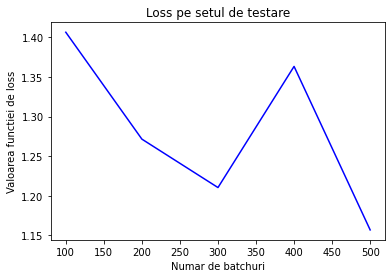

In [34]:
_, chan, w, h = batch_train_images_small.size()
net = ImprovedMLP(w, h, chan, len(SMALL_DS['target_names'])).to(device)

test_alg(net,
    small_train_loader, small_test_loader,
    torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-4),
    50)